In [1]:
#Import the libraries we need
import pandas as pd
import seaborn as sns
import numpy as np
from fredapi import Fred
import MetaTrader5 as mt5
from datetime import datetime
import time
import pytz

In [2]:
#Let's setup our FredAPI
fred = Fred(api_key="")
visa_discretionary = pd.DataFrame(fred.get_series("VISASMIDSA"),columns=["visa d"])
visa_headline      = pd.DataFrame(fred.get_series("VISASMIHSA"),columns=["visa h"])
visa_non_discretionary = pd.DataFrame(fred.get_series("VISASMINSA"),columns=["visa nd"])

In [3]:
#Define how far ahead we want to forecast
look_ahead = 10

<Axes: title={'center': 'VISA Spending Momentum Index: Discretionary'}>

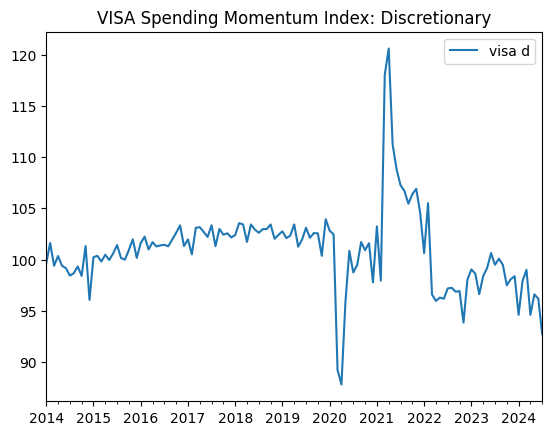

In [4]:
visa_discretionary.plot(title="VISA Spending Momentum Index: Discretionary")

<Axes: title={'center': 'VISA Spending Momentum Index: Headline'}>

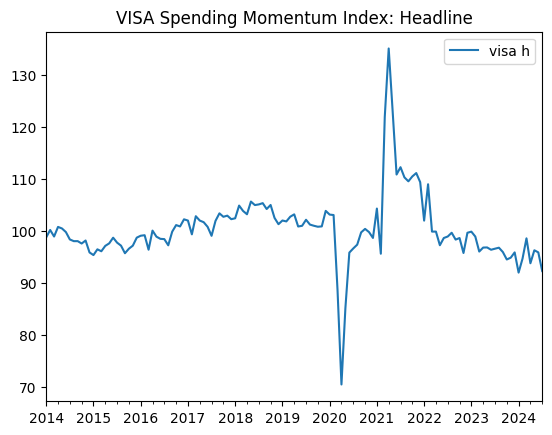

In [5]:
visa_headline.plot(title="VISA Spending Momentum Index: Headline")

<Axes: title={'center': 'VISA Spending Momentum Index: Non-Discretionary'}>

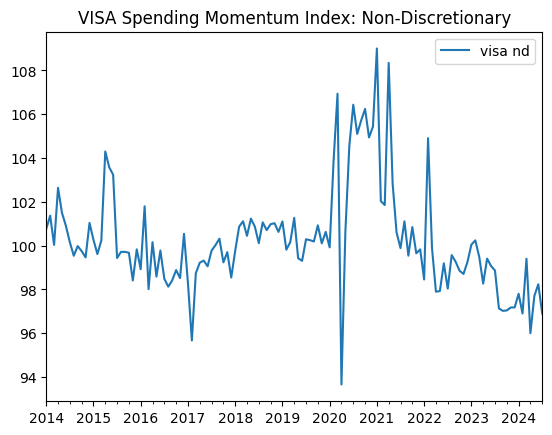

In [6]:
visa_non_discretionary.plot(title="VISA Spending Momentum Index: Non-Discretionary")

In [4]:
#Initialize the terminal
mt5.initialize()

True

In [5]:
#Set timezone to UTC
timezone = pytz.timezone("Etc/UTC")

In [6]:
#Create a 'datetime' object in UTC
utc_from = datetime(2024,7,1,tzinfo=timezone)

In [7]:
#Fetch the data
eurusd = pd.DataFrame(mt5.copy_rates_from("EURUSD",mt5.TIMEFRAME_MN1,utc_from,visa_headline.shape[0]))

In [8]:
#Format the time
eurusd["time"] = pd.to_datetime(eurusd["time"],unit="s")

In [9]:
#Label the data
eurusd["target"] = np.nan
eurusd.loc[eurusd["close"] > eurusd["close"].shift(-look_ahead),"target"] = 0
eurusd.loc[eurusd["close"] < eurusd["close"].shift(-look_ahead),"target"] = 1
eurusd.dropna(inplace=True)
eurusd.set_index("time",inplace=True)

In [10]:
#Let's merge the datasets
merged_data = eurusd.merge(visa_headline,right_index=True,left_index=True)
merged_data = merged_data.merge(visa_discretionary,right_index=True,left_index=True)
merged_data = merged_data.merge(visa_non_discretionary,right_index=True,left_index=True)

[Text(0.5, 1.0, 'EURUSD Close Against VISA Index: Non-Discretionary')]

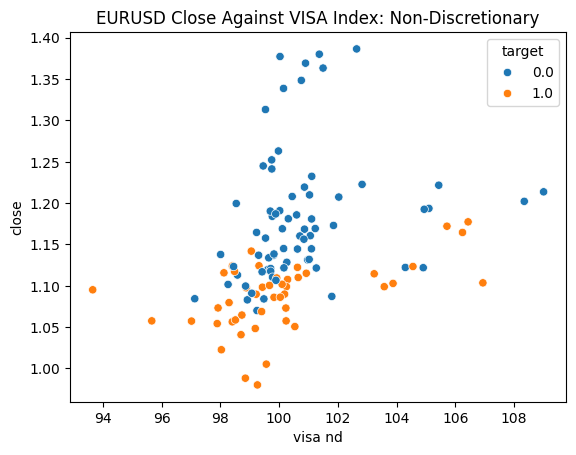

In [33]:
#Let's create scatter plots 
sns.scatterplot(data=merged_data,y="close",x="visa nd",hue="target").set(title="EURUSD Close Against VISA Index: Non-Discretionary")

[Text(0.5, 1.0, 'EURUSD Close Against VISA Index: Discretionary')]

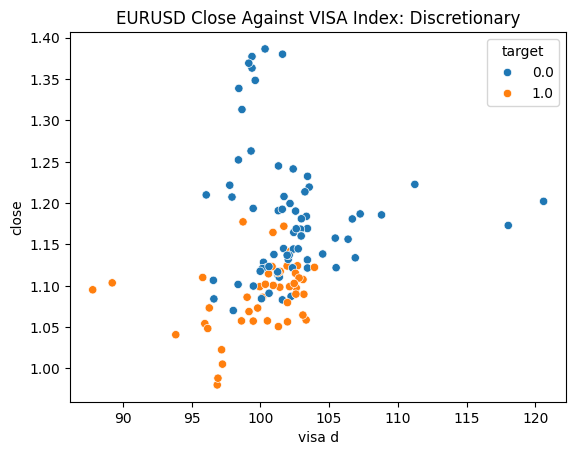

In [166]:
#Let's create scatter plots 
sns.scatterplot(data=merged_data,y="close",x="visa d",hue="target").set(title="EURUSD Close Against VISA Index: Discretionary")

[Text(0.5, 1.0, 'EURUSD Close Against VISA Momentum Index: Headline')]

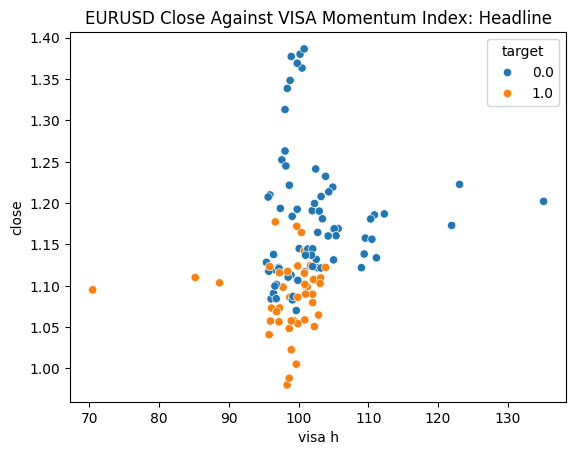

In [165]:
#Let's create scatter plots 
sns.scatterplot(data=merged_data,y="close",x="visa h",hue="target").set(title="EURUSD Close Against VISA Momentum Index: Headline")

In [81]:
#Is there any correlation
merged_data.corr()

index      open      high       low     close  tick_volume  \
index        1.000000 -0.479043 -0.511932 -0.461387 -0.467166    -0.322476   
open        -0.479043  1.000000  0.981399  0.980883  0.956446    -0.222985   
high        -0.511932  0.981399  1.000000  0.981977  0.979368    -0.162560   
low         -0.461387  0.980883  0.981977  1.000000  0.984790    -0.223894   
close       -0.467166  0.956446  0.979368  0.984790  1.000000    -0.195925   
tick_volume -0.322476 -0.222985 -0.162560 -0.223894 -0.195925     1.000000   
spread      -0.244644 -0.019876  0.031134 -0.010467  0.019802     0.368520   
real_volume -0.422992 -0.237023 -0.198645 -0.228167 -0.237859     0.532196   
target       0.130021 -0.533984 -0.550069 -0.564761 -0.564907     0.059462   
visa h       0.162986  0.180345  0.168421  0.205621  0.186368    -0.121539   
visa d       0.004965  0.172395  0.164099  0.205611  0.180697    -0.045391   
visa nd      0.044627  0.253838  0.311746  0.283952  0.313499    -0.034221   

               spread  real_volume    target    visa h    visa d   visa nd  
index       -0.244644    -0.422992  0.130021  0.162986  0.004965  0.044627  
open        -0.019876    -0.237023 -0.533984  0.180345  0.172395  0.253838  
high         0.031134    -0.198645 -0.550069  0.168421  0.164099  0.311746  
low         -0.010467    -0.228167 -0.564761  0.205621  0.205611  0.283952  
close        0.019802    -0.237859 -0.564907  0.186368  0.180697  0.313499  
tick_volume  0.368520     0.532196  0.059462 -0.121539 -0.045391 -0.034221  
spread       1.000000     0.346221  0.026726 -0.040863  0.027632 -0.149491  
real_volume  0.346221     1.000000  0.106326 -0.152052  0.005506 -0.243934  
target       0.026726     0.106326  1.000000 -0.309148 -0.292415 -0.132132  
visa h      -0.040863    -0.152052 -0.309148  1.000000  0.899223  0.319999  
visa d       0.027632     0.005506 -0.292415  0.899223  1.000000  0.262416  
visa nd     -0.149491    -0.243934 -0.132132  0.319999  0.262416  1.000000

In [145]:
#Let's see which features are the most important
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

In [15]:
#A few more libraries we need
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [16]:
#Create train test partitions for our alternative data
train_X,test_X,train_y,test_y = train_test_split(merged_data.loc[:,all_predictors],merged_data.loc[:,"target"],test_size=0.5,shuffle=False)

In [138]:
#Create the forward selection object
sfs = SFS(
    MLPClassifier(hidden_layer_sizes=(20,10,4),shuffle=False,activation=tuner.best_params_["activation"],solver=tuner.best_params_["solver"],alpha=tuner.best_params_["alpha"],learning_rate=tuner.best_params_["learning_rate"],learning_rate_init=tuner.best_params_["learning_rate_init"]),
    k_features=(1,train_X.shape[1]),
    forward=False,
    scoring="accuracy",
    cv=5
).fit(train_X,train_y)

Z:\home\volatily\Downloads\Python Env\MT5\MT5\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
Z:\home\volatily\Downloads\Python Env\MT5\MT5\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
Z:\home\volatily\Downloads\Python Env\MT5\MT5\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
Z:\home\volatily\Downloads\Python Env\MT5\MT5\lib\site-packages\sklearn\neural_network\

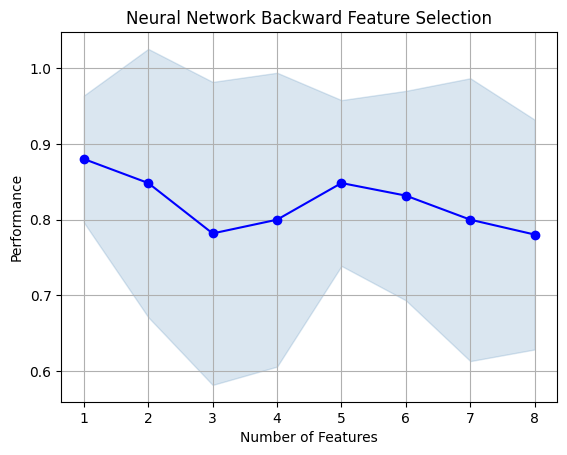

In [146]:
fig1 = plot_sfs(sfs.get_metric_dict(),kind="std_dev")
plt.title("Neural Network Backward Feature Selection")
plt.grid()

In [142]:
sfs.k_feature_names_

('open',)

In [32]:
#Mutual information
from sklearn.feature_selection import mutual_info_classif

In [33]:
#Mutual information from the first visa dataset, 
print(f"VISA Headline dataset has a mutual info score of: {mutual_info_classif(train_X.loc[:,['visa h']],train_y)[0]}")

VISA Headline dataset has a mutual info score of: 0.06069528690724346


In [34]:
#Mutual information from the second visa dataset, 
print(f"VISA Discretionary dataset has a mutual info score of: {mutual_info_classif(train_X.loc[:,['visa d']],train_y)[0]}")

VISA Discretionary dataset has a mutual info score of: 0.1277119388376886


In [38]:
#Mutual information from the third visa dataset, 
print(f"VISA Non-Discretionary dataset has a mutual info score of: {mutual_info_classif(train_X.loc[:,['visa nd']],train_y)[0]}")

VISA Non-Discretionary dataset has a mutual info score of: 0.12989543072404985


In [11]:
#Reset the index
merged_data.reset_index(inplace=True)

In [12]:
#Define the target
target = "target"
ohlc_predictors = ["open","high","low","close","tick_volume"]
visa_predictors = ["visa d","visa h","visa nd"]
all_predictors = ohlc_predictors + visa_predictors

In [13]:
#Let's scale the data
scale_factors = pd.DataFrame(index=["mean","standard deviation"],columns=all_predictors)

for i in np.arange(0,len(all_predictors)):
    #Store the mean and standard deviation for each column
    scale_factors.iloc[0,i] = merged_data.loc[:,all_predictors[i]].mean()
    scale_factors.iloc[1,i] = merged_data.loc[:,all_predictors[i]].std()
    merged_data.loc[:,all_predictors[i]] = ((merged_data.loc[:,all_predictors[i]] - scale_factors.iloc[0,i]) / scale_factors.iloc[1,i])

scale_factors

C:\users\volatily\Temp\ipykernel_520\8853927.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.18578408 -1.41023355 -0.8116665  -1.14152618 -1.3192999  -1.3217948
 -1.27784961 -1.25980859 -0.90444357 -0.23789098 -0.36936851 -0.35543013
 -0.44703793 -0.75291732 -0.29249559 -0.12819344 -0.26698798  1.38329501
  1.53545462  1.41728212  1.43855224  1.07826879  1.10666559  1.2038365
  1.58057248  2.11017847  1.24531058  1.09613873  0.84257753  1.56751446
  0.7383162   0.50722498  0.70638552  0.69034767  1.65086144  0.66742334
  1.43124655  0.59646024  0.90468497  0.09426306  0.56642284  0.52606252
  0.50736547  1.38963991  1.67382769  1.09079089  0.73130736  0.24610542
  1.87114368  2.27231996  1.82270721  1.00306934  1.69821247  1.82782392
  1.24495707  1.20912769  0.17223613  0.5812291   0.35386211 -0.11788525
  0.01493263 -0.74371609 -0.88322783 -1.1046986  -0.93245967 -0.85883172
 -1.0004622  -0.59279487 -0.93

open      high       low     close     tick_volume  \
mean                1.146534  1.165568   1.12575  1.143893  1956097.470085   
standard deviation  0.082951  0.079607  0.083908  0.080632   882599.530576   

                        visa d      visa h     visa nd  
mean                101.271017  100.848506  100.477269  
standard deviation    3.981438    6.565229    2.367663

In [14]:
#Let's see the normalized data
merged_data

index      open      high       low     close  tick_volume  spread  \
0   2014-01-01  2.760266  2.662084  2.647548  2.537418    -1.185784       1   
1   2014-02-01  2.435375  2.723887  2.645165  2.930191    -1.410234       1   
2   2014-03-01  2.797155  2.902891  2.916534  2.895341    -0.811666       1   
3   2014-04-01  2.782448  2.826390  2.878158  3.009192    -1.141526       1   
4   2014-05-01  2.893598  2.936305  2.774831  2.722208    -1.319300       1   
..         ...       ...       ...       ...       ...          ...     ...   
112 2023-05-01 -0.534216 -0.708078 -0.741643 -0.930940    -0.946864       0   
113 2023-06-01 -0.935056 -0.808194 -0.709942 -0.656235    -1.023719       0   
114 2023-07-01 -0.668874 -0.477321 -0.505432 -0.548213    -0.920270       0   
115 2023-08-01 -0.565198 -0.741995 -0.585997 -0.738089    -0.758202       0   
116 2023-09-01 -0.750489 -0.971873 -0.916955 -1.073688    -1.060197       0   

     real_volume  target    visa h    visa d   visa nd  
0              0     0.0 -0.314554 -0.412674  0.118312  
1              0     0.0 -0.097085  0.086045  0.376584  
2              0     0.0 -0.289728 -0.471911 -0.187923  
3              0     0.0 -0.008047 -0.233157  0.913288  
4              0     0.0 -0.053343 -0.471505  0.430792  
..           ...     ...       ...       ...       ...  
112            0     1.0 -0.609887 -0.526639 -0.452507  
113            0     0.0 -0.677476 -0.160039 -0.593825  
114            0     0.0 -0.646435 -0.446567 -0.682647  
115            0     0.0 -0.617400 -0.298681 -1.413451  
116            0     1.0 -0.744559 -0.449147 -1.460138  

[117 rows x 12 columns]

In [123]:
tuner = RandomizedSearchCV(MLPClassifier(hidden_layer_sizes=(20,10,4),shuffle=False),
                           {
                               "activation": ["relu","identity","logistic","tanh"],
                               "solver": ["lbfgs","adam","sgd"],
                               "alpha": [0.1,0.01,0.001,(10.0 ** -4),(10.0 ** -5),(10.0 ** -6),(10.0 ** -7),(10.0 ** -8),(10.0 ** -9)],
                               "learning_rate": ["constant", "invscaling", "adaptive"],
                               "learning_rate_init": [0.1,0.01,0.001,(10.0 ** -4),(10.0 ** -5),(10.0 ** -6),(10.0 ** -7),(10.0 ** -8),(10.0 ** -9)],
                           },
                           cv=5,
                           n_iter=1000,
                           scoring="accuracy",
                           return_train_score=False
                          )

In [124]:
tuner.fit(train_X,train_y)

Z:\home\volatily\Downloads\Python Env\MT5\MT5\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Z:\home\volatily\Downloads\Python Env\MT5\MT5\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Z:\home\volatily\Downloads\Python Env\MT5\MT5\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
Z:\home\volatily\Downloads\Python Env\MT5\MT5\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  war

RandomizedSearchCV(cv=5,
                   estimator=MLPClassifier(hidden_layer_sizes=(20, 10, 4),
                                           shuffle=False),
                   n_iter=1000,
                   param_distributions={'activation': ['relu', 'identity',
                                                       'logistic', 'tanh'],
                                        'alpha': [0.1, 0.01, 0.001, 0.0001,
                                                  1e-05, 1e-06, 1e-07, 1e-08,
                                                  1e-09],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'learning_rate_init': [0.1, 0.01, 0.001,
                                                               0.0001, 1e-05,
                                                               1e-06, 1e-07,
                                                               1e-08, 1e-09],
                                        'solver': ['lbfgs', 'adam', 'sgd']},
                   scoring='accuracy')

In [125]:
tuner_results = pd.DataFrame(tuner.cv_results_)
params = ["param_activation","param_solver","param_alpha","param_learning_rate","param_learning_rate_init","mean_test_score"]
tuner_results.loc[:,params].sort_values(by="mean_test_score",ascending=False)

param_activation param_solver param_alpha param_learning_rate  \
228         logistic        lbfgs     0.00001            constant   
62              relu        lbfgs         0.0            adaptive   
499         identity         adam    0.000001            constant   
486             relu        lbfgs       0.001          invscaling   
454             tanh          sgd      0.0001            constant   
..               ...          ...         ...                 ...   
412         identity         adam         0.1            constant   
401             tanh          sgd     0.00001            constant   
293         identity         adam    0.000001          invscaling   
528         identity          sgd    0.000001          invscaling   
979         identity         adam         0.0            constant   

    param_learning_rate_init  mean_test_score  
228                  0.00001         0.881818  
62                       0.1         0.850000  
499                   0.0001         0.850000  
486                     0.01         0.850000  
454                    0.001         0.850000  
..                       ...              ...  
412                      0.0         0.296970  
401                  0.00001         0.292424  
293                  0.00001         0.278788  
528                      0.0         0.204545  
979                 0.000001         0.187879  

[1000 rows x 6 columns]

In [132]:
#Let's compare the default model and our customized model on the hold out set
default_model = MLPClassifier(hidden_layer_sizes=(20,10,4),shuffle=False)
customized_model = MLPClassifier(hidden_layer_sizes=(20,10,4),shuffle=False,activation=tuner.best_params_["activation"],solver=tuner.best_params_["solver"],alpha=tuner.best_params_["alpha"],learning_rate=tuner.best_params_["learning_rate"],learning_rate_init=tuner.best_params_["learning_rate_init"])

In [133]:
#The accuracy of the defualt model
default_model.fit(train_X,train_y)
accuracy_score(test_y,default_model.predict(test_X))

Z:\home\volatily\Downloads\Python Env\MT5\MT5\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.5423728813559322

In [134]:
#The accuracy of the defualt model
customized_model.fit(train_X,train_y)
accuracy_score(test_y,customized_model.predict(test_X))

0.7457627118644068

In [4]:
#Let us now start building our trading strategy
SYMBOL = 'EURUSD'
TIMEFRAME = mt5.TIMEFRAME_MN1
DEVIATION = 1000
VOLUME = 0
LOT_MULTIPLE = 1

In [5]:
#Trying to log in
if not mt5.initialize():
    print('Failed To Log in')

In [6]:
#Let's fetch the trading volume
for index,symbol in enumerate(mt5.symbols_get()):
    if symbol.name == SYMBOL:
        print(f"{symbol.name} has minimum volume: {symbol.volume_min}")
        VOLUME = symbol.volume_min * LOT_MULTIPLE

EURUSD has minimum volume: 0.01


In [17]:
#A function to get current prices
def get_prices():
    start = datetime(2024,1,1)
    end   = datetime.now()
    data  = pd.DataFrame(mt5.copy_rates_range(SYMBOL,TIMEFRAME,start,end))
    data['time'] = pd.to_datetime(data['time'],unit='s')
    data.set_index('time',inplace=True)
    return(data.iloc[-1,:])

In [18]:
#A function to get our alternative data
def get_alternative_data():
    visa_d = fred.get_series_as_of_date("VISASMIDSA",datetime.now())
    visa_d = visa_d.iloc[-1,-1]
    visa_h = fred.get_series_as_of_date("VISASMIHSA",datetime.now())
    visa_h = visa_h.iloc[-1,-1]
    visa_n = fred.get_series_as_of_date("VISASMINSA",datetime.now())
    visa_n = visa_n.iloc[-1,-1]
    return(visa_d,visa_h,visa_n)

In [116]:
#A function to prepare the inputs for our model
def get_model_inputs():
    LAST_OHLC = get_prices()
    visa_d , visa_h , visa_n = get_alternative_data()
    return(
           np.array([[
                       ((LAST_OHLC['open'] - scale_factors.iloc[0,0]) / scale_factors.iloc[1,0]),
                       ((LAST_OHLC['high']  - scale_factors.iloc[0,1]) / scale_factors.iloc[1,1]),
                       ((LAST_OHLC['low']  - scale_factors.iloc[0,2]) / scale_factors.iloc[1,2]),
                       ((LAST_OHLC['close']  - scale_factors.iloc[0,3]) / scale_factors.iloc[1,3]),
                       ((LAST_OHLC['tick_volume']  - scale_factors.iloc[0,4]) / scale_factors.iloc[1,4]),
                       ((visa_d  - scale_factors.iloc[0,5]) / scale_factors.iloc[1,5]),
                       ((visa_h  - scale_factors.iloc[0,6]) / scale_factors.iloc[1,6]),
                       ((visa_n  - scale_factors.iloc[0,7]) / scale_factors.iloc[1,7])
                   ]])
          )

In [113]:
#Let's train our model on all the data we have
model = MLPClassifier(hidden_layer_sizes=(20,10,4),shuffle=False,activation="logistic",solver="lbfgs",alpha=0.00001,learning_rate="constant",learning_rate_init=0.00001)
model.fit(merged_data.loc[:,all_predictors],merged_data.loc[:,"target"])

MLPClassifier(activation='logistic', alpha=1e-05,
              hidden_layer_sizes=(20, 10, 4), learning_rate_init=1e-05,
              shuffle=False, solver='lbfgs')

In [117]:
#A function to get a prediction from our model
def ai_forecast():
    model_inputs = get_model_inputs()
    prediction = model.predict(model_inputs)
    return(prediction[0])

In [ ]:
while True:
    #Get data on the current state of our terminal and our portfolio
    positions = mt5.positions_total()
    forecast  = ai_forecast()
    BUY_STATE , SELL_STATE = False , False

    #Interpret the model's forecast
    if(forecast == 0.0):
        SELL_STATE = True
        BUY_STATE  = False 

    elif(forecast == 1.0):
        SELL_STATE = False
        BUY_STATE  = True

    print(f"Our forecast is {forecast}")

    #If we have no open positions let's open them
    if(positions == 0):
        print(f"We have {positions} open trade(s)")
        if(SELL_STATE):
            print("Opening a sell position")
            mt5.Sell(SYMBOL,VOLUME)
        elif(BUY_STATE):
            print("Opening a buy position")
            mt5.Buy(SYMBOL,VOLUME)

    #If we have open positions let's manage them
    if(positions > 0):
        print(f"We have {positions} open trade(s)")
        for pos in mt5.positions_get():
            if(pos.type == 1):
                if(BUY_STATE):
                    print("Closing all sell positions")
                    mt5.Close(SYMBOL)
            if(pos.type == 0):
                if(SELL_STATE):
                    print("Closing all buy positions")
                    mt5.Close(SYMBOL)
    #If we have finished all checks then we can wait for one day before checking our positions again
    time.sleep(24 * 60 * 60)

Z:\home\volatily\Downloads\Python Env\MT5\MT5\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


Our forecast is 0.0
We have 0 open trade(s)
Opening a sell position
